## LIPO Implementation

This is intended to be a place for investigations and experimentation with the LIPO algorithm outlined [here](https://arxiv.org/abs/1703.02628). Further ideas and more accessible description located [here](http://blog.dlib.net/2017/12/a-global-optimization-algorithm-worth.html).

This notebook is meant to address some of the concerns brought up at the end of [this notebook](./LIPO-investigation.ipynb) where I was doing some initial exploration of the ideas behind the algorithm and looking at pictures.

Here we focus more on the implementation of LIPO than investigating the upper bound idea behind it.

#### Inputs: 
- $n$, the number of iterations to perform; 
- $k\geq 0$, the known lipschitz constant; 
- $f$, the expensive function to minimize; 
- $\Omega\subset\mathbb{R}^d$, the domain of $f$.

#### Algorithm

Initialization:

- Let $X_1\sim U(\Omega)$ and evaluate $f(X_1)$

Iteration:

For $2\leq t\leq n$:

- Let $X_t\sim U(\Omega)$.
- If $\max_{i=1,\dots,t-1}\big(f(X_i)-k\cdot || X_t - X_i ||\big) \leq \min_{i=1,\dots,t-1}f(X_i)$, evaluate $f(X_t)$

Output:

- Returns $X_{\eta}$ where $\eta = \arg\min_{i=1,\dots,n}f(X_i)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

In [15]:
def lower_bound(x_prop, y, x, k):
    """
    Parameters
    ----------
     - x_prop: candidate point at which to evaluate f
     - y:      values of f already seen
     - x:      values in domain correponding to y
     - k:      lipschitz constant of f
    Returns
    -------
     - lower bound on f 
    """
    return np.max(y - k * np.linalg.norm(x_prop - x))


def LIPO(f, bounds, k, n, seq_out=False):
    """
    Parameters
    ----------
     - f:      the (expensive) function to be minimized
     - bounds: list of tuples containing boundaries defining the domain of f 
     - k:      the lipschitz constant of f
     - n:      number of iterations to perform
    Returns
    ------
     - x within bounds that returned smallest value f(x)
    """
    
    # initialization
    y = []
    x = []
    best = []
    
    bound_mins = np.array([bnd[0] for bnd in bounds])
    bound_maxs = np.array([bnd[1] for bnd in bounds])
    
    u = np.random.uniform(size=len(bounds))
    x_prop = u * (bound_maxs - bound_mins) + bound_mins
    
    x.append(x_prop)
    y.append(f(x[0]))
    
    # iteration
    for t in np.arange(n):
        u = np.random.uniform(size=len(bounds))
        x_prop = u * (bound_maxs - bound_mins) + bound_mins
        if lower_bound(x_prop, y, x, k) <= np.min(y):
            x.append(x_prop)
            y.append(f(x_prop))
        best.append(x[np.array(y).argmin()])
            
    # output
    if seq_out:
        return np.array(best).reshape(n)
    else:
        return x[np.array(y).argmin()]

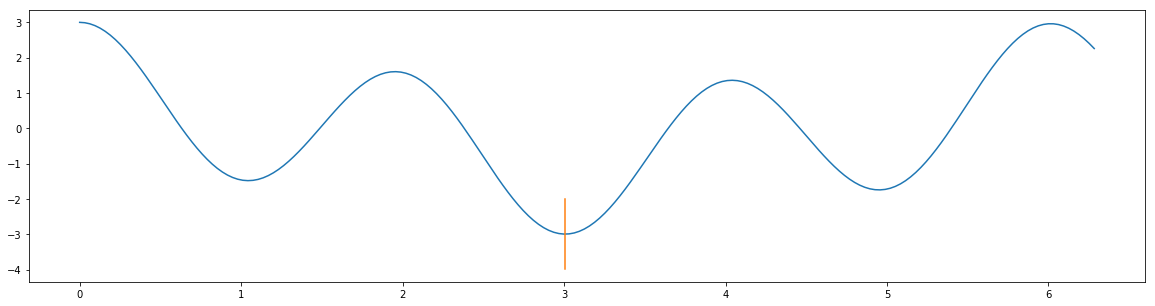

In [16]:
def f(x):
    return (np.cos(x) + 2*np.cos(np.pi*x))
grid = np.linspace(0,2*np.pi,200)
bnds = [(0,2*np.pi)]

mini = LIPO(f, bnds, 10, 1000)
f_mini = f(mini)
ys = np.linspace(f_mini - 1, f_mini + 1,100)

plt.figure(figsize=(20,5))
plt.plot(grid, f(grid))
plt.plot(np.ones(100)*mini,ys);

Lets experiment with the number of iterations in the algorithm paying particular attention to the concentration of the estimated minimizer.

In [11]:
num_iters = [2**p for p in range(3,11)]
num_sims = 100

results = np.zeros((len(num_iters), num_sims))

for counter, niter in enumerate(num_iters):
    for sim in np.arange(num_sims):
        results[counter, sim] = LIPO(f, bnds, 10, niter)

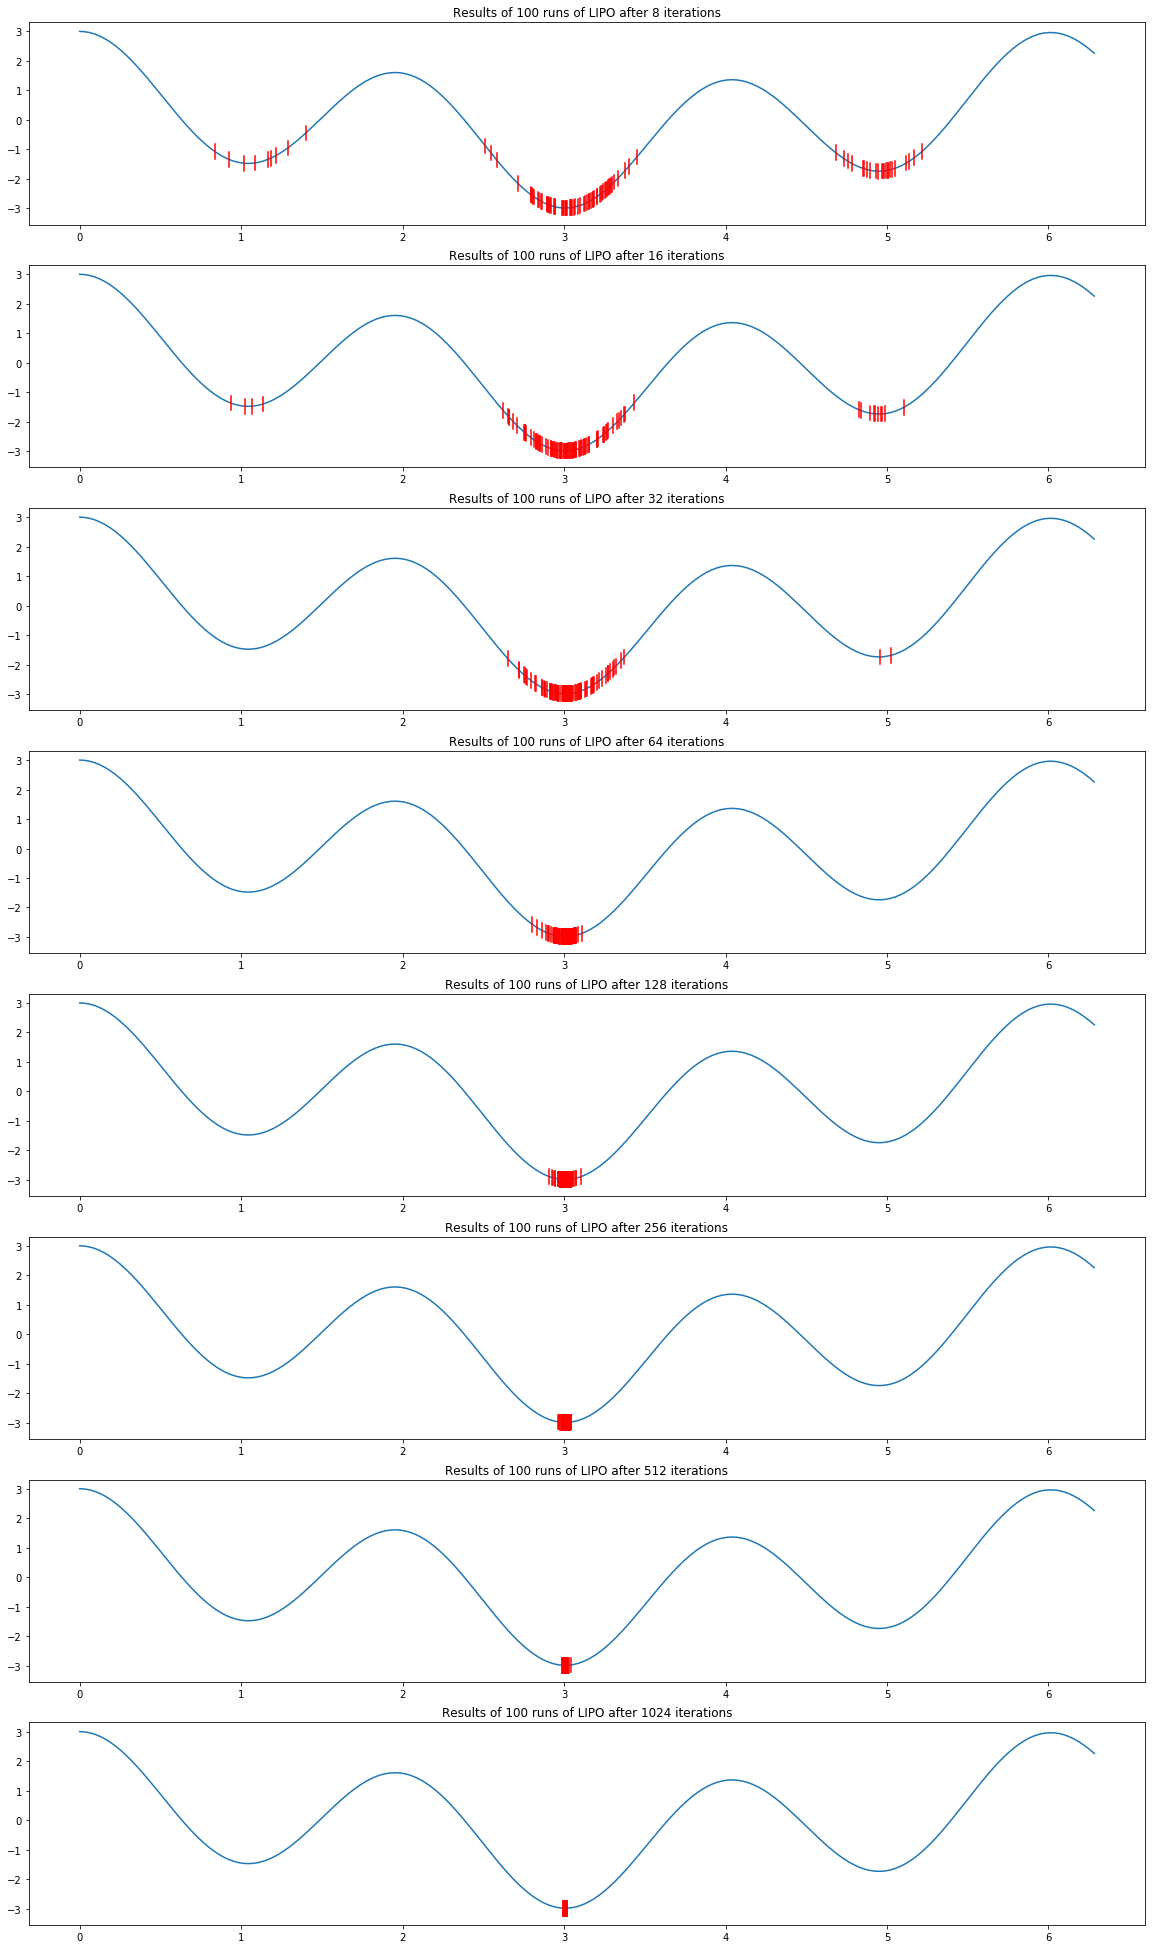

In [13]:
plt.figure(figsize=(20,35))

for i in range(len(num_iters)): 
    plt.subplot(len(num_iters), 1, i+1)
    plt.title('Results of {} runs of LIPO after {} iterations'.format(num_sims, num_iters[i]))
    plt.plot(grid, f(grid))
    for j in range(num_sims):
        f_mini = f(results[i, j])
        ys = np.linspace(f_mini - 0.25, f_mini + 0.25,10)
        plt.plot(np.ones(10)*results[i, j],ys, color='red')

This is pretty neat! Seeing it quickly (from what I can tell) distinguish the neighborhood that contains the global minimum is impressive.

What is missing at this point?

The above implementation is assuming knowledge of the lipschitz constant $k$. This is not usually the case and thus we need a version that can estimate $k$ while performing the minimization (called adaptive LIPO).

We will address this algorithm in the next notebook.